In [1]:
import gc
import glob
import os
import sys
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from random import randrange
from tqdm import tqdm, tnrange
from tqdm.notebook import tqdm_notebook

import warnings

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from keras.optimizer_v2.gradient_descent import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, MaxPooling2D, Flatten, Conv2D, Lambda, Dropout, LeakyReLU, BatchNormalization, Activation, AveragePooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

from mlxtend.evaluate import accuracy

from tensorflow.keras.optimizers import Adam,RMSprop,SGD, Nadam
#from tensorflow.keras.utils import to_categorical
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # ignore tensorflow warnings
warnings.filterwarnings("ignore")

In [3]:
path_data = "data/NIR"

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_data,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(128, 128),
    shuffle=True,
    seed=1007,
    validation_split=0.3,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)


Found 6000 files belonging to 500 classes.
Using 4200 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_data,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(128, 128),
    shuffle=True,
    seed=1007,
    validation_split=0.15,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 6000 files belonging to 500 classes.
Using 900 files for validation.


In [6]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_data,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(128, 128),
    shuffle=True,
    seed=1007,
    validation_split=0.15,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 6000 files belonging to 500 classes.
Using 900 files for validation.


In [7]:
from keras.applications.efficientnet import EfficientNetB0
from keras.applications.inception_v3 import InceptionV3

def resnet_model_tf(input_shape=(128, 128, 3), nombre_classes=500):
    resnet = EfficientNetB0(weights=None, include_top=False, input_shape=input_shape)
    resnet.tbatch_sizenable = False
    model = Sequential()
    model.add(resnet)
    model.add(Flatten())
#    model.add(Dense(4096, activation='LeakyReLU'))
#    model.add(Dropout(0.5))
#    model.add(Dense(4096, activation='LeakyReLU'))
#    model.add(Dropout(0.5))
    model.add(Dense(nombre_classes, activation='softmax'))
    
    print(model.summary())
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.7, 
                                            min_lr=0.00000000001)
    return model, learning_rate_reduction

In [8]:
model, learning_rate_reduction = resnet_model_tf()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 500)               10240500  
                                                                 
Total params: 14,290,071
Trainable params: 14,248,048
Non-trainable params: 42,023
_________________________________________________________________
None


In [9]:
epochs = 100
batch = 64

print("\n ================= Training : RESNET model ================= \n")
print("             Epochs :  {}   |   Batch size : {} ".format(epochs, batch))
print("\n =========================================================== \n")
trained = model.fit(train_ds, validation_data = val_ds, epochs=epochs, batch_size=batch, callbacks=[learning_rate_reduction])


 ================= Training : RESNET model ================= 

             Epochs :  100   |   Batch size : 64 


Epoch 1/100
66/66 [==============================] - 24s 258ms/step - loss: 7.4020 - accuracy: 0.0093 - val_loss: 6.4680 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
66/66 [==============================] - 16s 234ms/step - loss: 4.1897 - accuracy: 0.2569 - val_loss: 6.5366 - val_accuracy: 0.0033 - lr: 0.0010
Epoch 3/100
66/66 [==============================] - 16s 234ms/step - loss: 0.8556 - accuracy: 0.8079 - val_loss: 7.0815 - val_accuracy: 0.0044 - lr: 0.0010
Epoch 4/100
66/66 [==============================] - 16s 235ms/step - loss: 0.2874 - accuracy: 0.9348 - val_loss: 8.6268 - val_accuracy: 0.0067 - lr: 0.0010
Epoch 5/100
66/66 [==============================] - 16s 235ms/step - loss: 0.2158 - accuracy: 0.9514 - val_loss: 11.1180 - val_accuracy: 0.0022 - lr: 0.0010
Epoch 6/100
66/66 [==============================] - 16s 234ms/step - loss: 0.2457 - accuracy:

In [10]:
val = model.evaluate(test_ds)
input_shape = (128, 128, 3)

print("\n ================= Evaluation : Resnet model ================= \n")
print("  With : \n")
print("Batch size         :  {}     |   Epochs      : {} ".format(batch, epochs))
print("Nombres de classes :  {}    |   Input shape : {} \n".format(len(train_ds.class_names), input_shape))
print("\n ============================================================= \n")

print("  Results : \n")
print("Loss  : %.2f%%" % (val[0] * 100))
print("Score : %.2f%%" % (val[1] * 100))

15/15 [==============================] - 1s 52ms/step - loss: 0.0124 - accuracy: 0.9967

 ================= Evaluation : Resnet model ================= 

  With : 

Batch size         :  64     |   Epochs      : 100 
Nombres de classes :  500    |   Input shape : (128, 128, 3) 



  Results : 

Loss  : 1.24%
Score : 99.67%


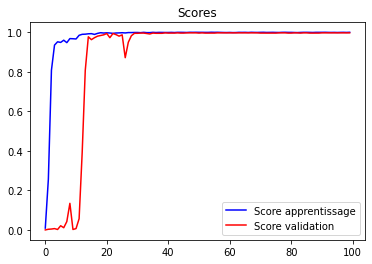

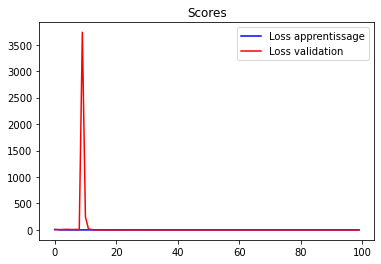

In [11]:
def plot_scores(train):
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()
def plot_loss(train):
    loss = train.history['loss']
    val_loss = train.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'b', label='Loss apprentissage')
    plt.plot(epochs, val_loss, 'r', label='Loss validation')
    plt.title('Scores')
    plt.legend()
    plt.show()
    
plot_scores(trained)
plot_loss(trained)